In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: van Winden, Jurrien (0961816)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

I chose to use the categorical_crossentropy loss function together with adagrad. As we need to categorize each digit it seemed natural to use this loss function. For the layers I opted to go for usual 'relu', because of the cheap performance. The output layer is a 'softmax' layer. To pick the best features which categorize these digits. because 'adagrad' lowers the learning rate for parameters that get updated often, the cutoff in parameters is hopefully less impactful on accuracy. (length: 487)

(15887, 32, 32, 3)


Max val score: 76.82%


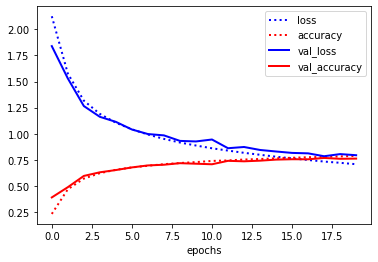

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 2000)              6146000   
_________________________________________________________________
dense_30 (Dense)             (None, 1000)              2001000   
_________________________________________________________________
dense_31 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_32 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_33 (Dense)             (None, 125)               31375     
_________________________________________________________________
dense_34 (Dense)             (None, 60)               

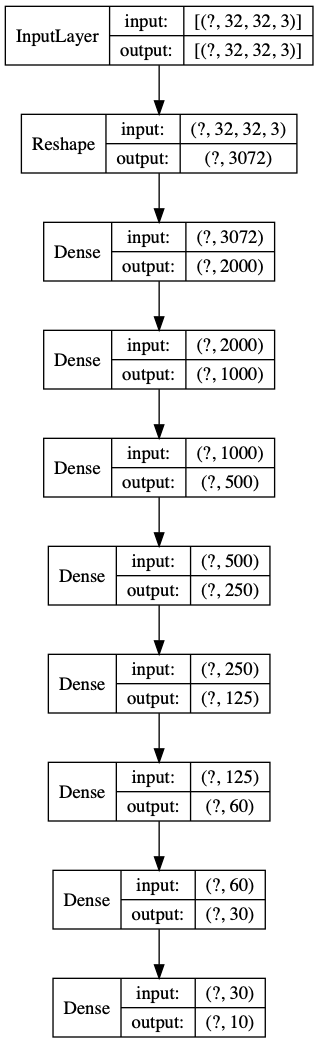

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

We used the helper function to greyscale X_train and X_val. This gives a new input shape (32, 32, 1) So the first reshape layer now only needs to reshape to 1024 * 32 * 32 length array. The model does not see major improvements due to the greyscaling. Model_1_2 sees accuracy improvements over model_1_1. (length: 305)

(15887, 32, 32, 3)


Max val score: 78.38%


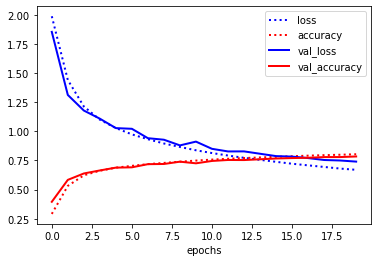

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 2000)              2050000   
_________________________________________________________________
dense_38 (Dense)             (None, 1000)              2001000   
_________________________________________________________________
dense_39 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_40 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_41 (Dense)             (None, 125)               31375     
_________________________________________________________________
dense_42 (Dense)             (None, 60)              

def build_model_1_2():
  model_1_2 = models.Sequential()
  print(X_val.shape)
  # Create layers
  model_1_2.add(layers.Reshape((1024,), input_shape=(32,32,1)))
  model_1_2.add(layers.Dense(2000, activation='relu'))  
  model_1_2.add(layers.Dense(1000, activation='relu'))
  model_1_2.add(layers.Dense(500, activation='relu'))
  model_1_2.add(layers.Dense(250, activation='relu'))
  model_1_2.add(layers.Dense(125, activation='relu'))
  model_1_2.add(layers.Dense(60, activation='relu'))
  model_1_2.add(layers.Dense(30, activation='relu'))
  model_1_2.add(layers.Dense(10, activation='softmax'))

  # Compile model
  model_1_2.compile(optimizer='adagrad',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

  return model_1_2



In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

We use a dropout layer to prevent overfitting, so we can run for more epochs. Upped learning rate in the optimizer made significant improvements in accuracy. Increased batch size increases performance a lot, but accuracy suffers a little. Decided to go with the increased learning rate, 20 epochs and normal batch rate. (length: 320)

(15887, 32, 32, 3)


Max val score: 82.32%


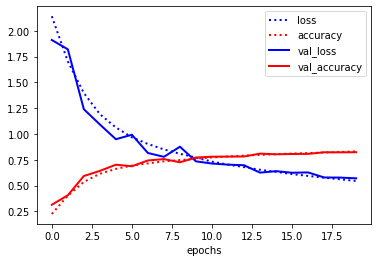

def build_model_1_3():
  model_1_3 = models.Sequential()
  print(X_val.shape)
  # Create layers
  model_1_3.add(layers.Reshape((1024,), input_shape=(32,32,1)))
  model_1_3.add(layers.Dense(1000, activation='relu'))
  model_1_3.add(layers.Dense(500, activation='relu'))
  model_1_3.add(layers.Dropout(0.2))
  model_1_3.add(layers.Dense(250, activation='relu'))
  model_1_3.add(layers.Dense(125, activation='relu'))
  model_1_3.add(layers.Dropout(0.3))
  model_1_3.add(layers.Dense(60, activation='relu'))
  model_1_3.add(layers.Dense(30, activation='relu'))
  model_1_3.add(layers.Dense(10, activation='softmax'))

  # Optimizer 
  adagrad = optimizers.Adagrad(learning_rate=0.02)
  # Compile model
  model_1_3.compile(optimizer=adagrad,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

  return model_1_3



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

Decided to go for 3 stacks of conv layers, and dense layers in the end. Used Adam with a smaller learning rate, instead of rmsprop. Adam performs better. Went with AveragePooling, tried MaxPooling but in my case it performed slightly worse. Introducing dropouts helps immensely with preventing overfit, also improves accuracy. More steep dropout seems to work better than small dropouts. Lastly I increased the batch size, together with taking a little larger convolution window. In my experiments that gave better performance than using (3,3) windows, or smaller batch sizes. Batchnormalization also helped with the accuracy of the model. I decided to introduce it after each pooling layer. And once in the dense layers. (length: 722)



Max val score: 95.22%


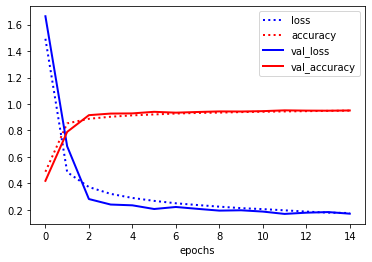

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        544       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        16416     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)       

def build_model_2_1():

  # Create model
  model_2_1 = models.Sequential()

  model_2_1.add(layers.Conv2D(32, (4, 4), activation='relu', padding='same', input_shape=(32, 32, 1)))
  model_2_1.add(layers.Conv2D(32, (4, 4), activation='relu', padding='same'))
  model_2_1.add(layers.BatchNormalization())
  model_2_1.add(layers.AveragePooling2D((2, 2)))
  model_2_1.add(layers.Dropout(0.3))

  model_2_1.add(layers.Conv2D(64, (4, 4), activation='relu', padding='same'))
  model_2_1.add(layers.Conv2D(64, (4, 4), activation='relu', padding='same'))
  model_2_1.add(layers.BatchNormalization())
  model_2_1.add(layers.AveragePooling2D((2, 2)))
  model_2_1.add(layers.Dropout(0.4))

  model_2_1.add(layers.Conv2D(128, (4, 4), activation='relu', padding='same'))
  model_2_1.add(layers.Conv2D(128, (4, 4), activation='relu', padding='same'))
  model_2_1.add(layers.BatchNormalization())
  model_2_1.add(layers.GlobalAveragePooling2D())
  model_2_1.add(layers.Dropout(0.5))

  model_2_1.add(layers.Flatten())

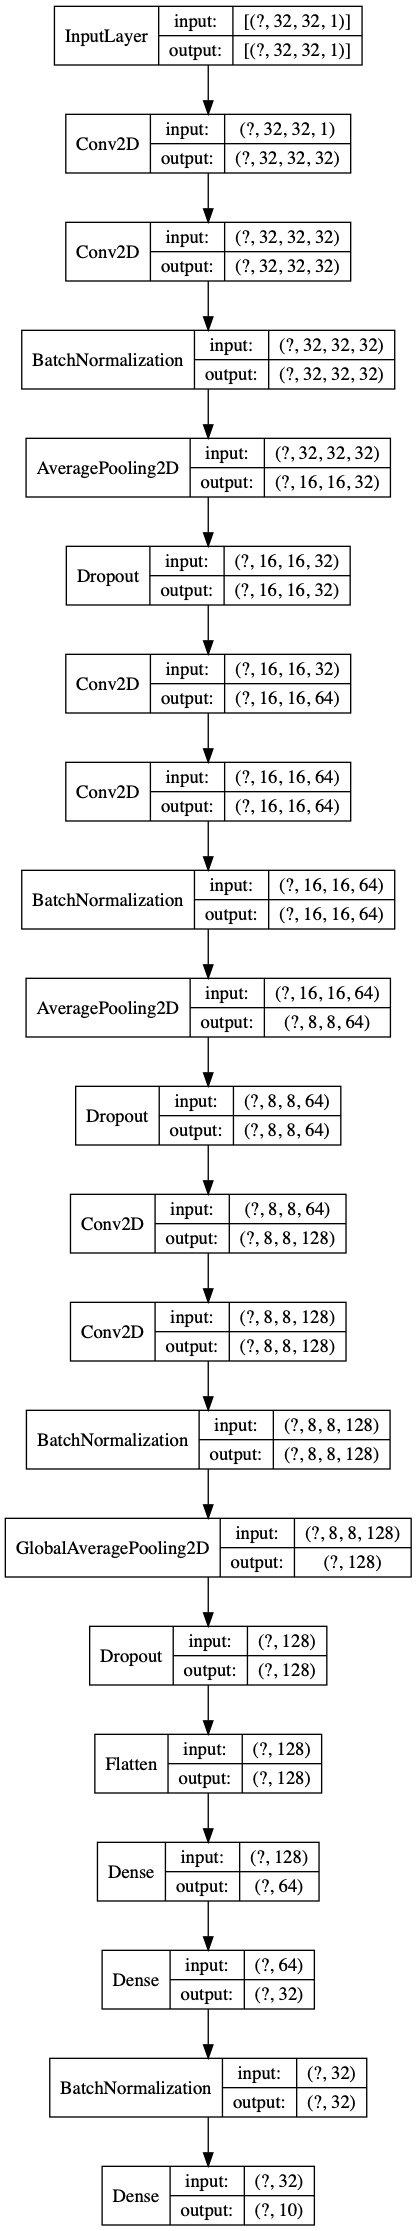

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

Large changes very inefficient or do not provide improvements at all. Subtle changes seem more promising (parameters <0.1). Maybe due to the nature of the input images. Zooming and shearing seem to help create a more accurate model. Shifting not that useful. channel shifts may provide useful for small values. Flips dont add value. (length: 333)



Max val score: 95.37%


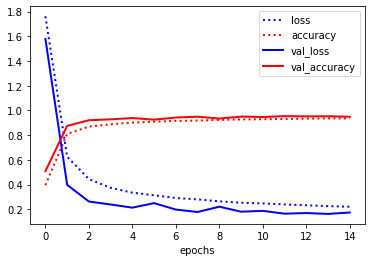


datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
    )


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

We observe that 2 and 5 are most often misclassified as 7 from the confusion matrix. Misclassified tend images to be extremely noisy, or have an extremely bad resolution. Or a number is written in a way that closely resembles another, this can be further amplified due to noise. (length: 279)

Test score: 0.95%


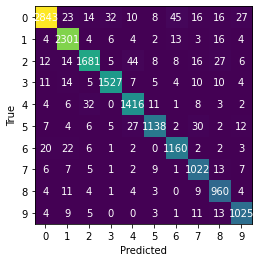

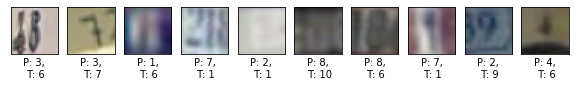

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

In the first layers we can clearly see the silhouettes of a '6' and '9'. It seems that layers learn features that are part of the '9' or that are around the '9'. Learning the features around the number itself might not be as useful. But it seems that we can still get okay results. Later layers become harder to interpret as we keep zooming in with our convolution windows. (length: 374)



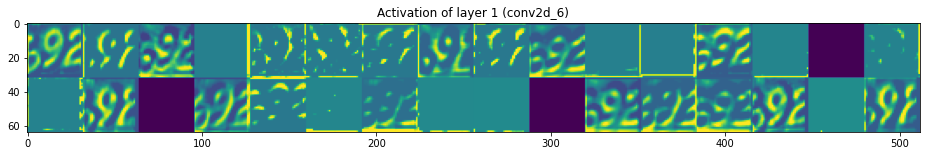

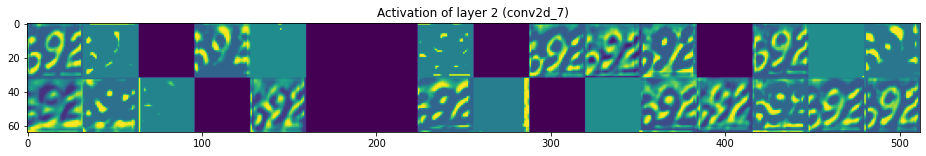

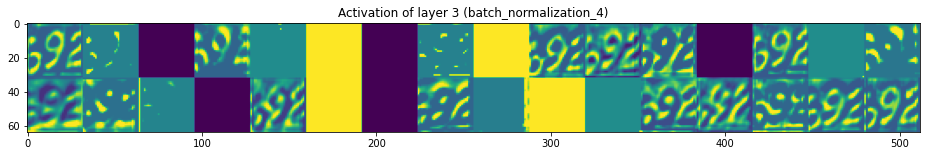

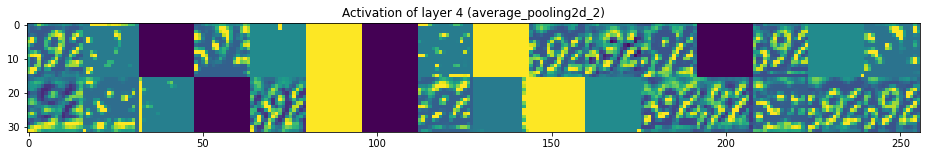

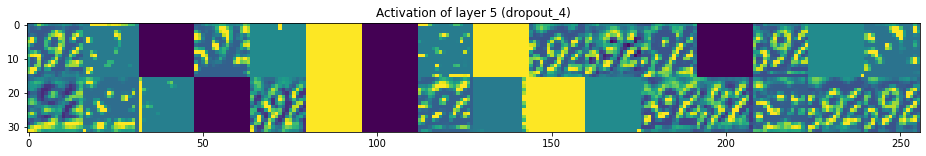

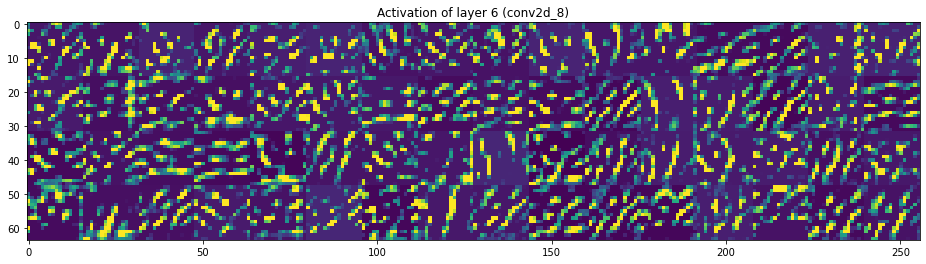

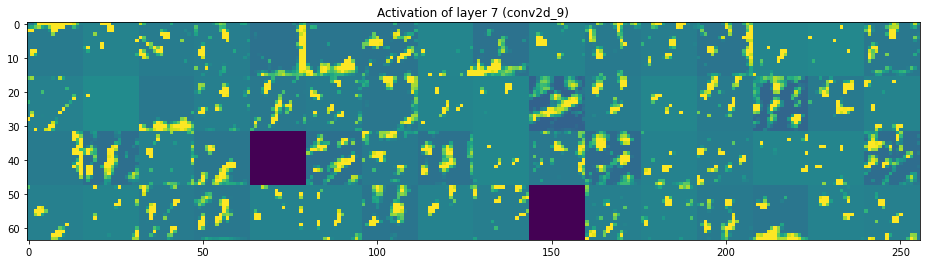

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

(16, 16, 32)
def plot_activation_map():
  X_train, X_val, y_train, y_val = preprocessed_split
  # Note that this uses the preprocessed data
  img_tensor = X_val[0]
  img_tensor = np.expand_dims(img_tensor, axis=0) 

  # Extracts the outputs of the layers:
  layer_outputs = [model_2_2.layers[-16].output]

  # Creates a model that will return these outputs, given the model input:
  activation_model = models.Model(inputs=model_2_2.input, outputs=layer_outputs)
  activations = activation_model.predict(img_tensor)

  # Produce map
  plt.rcParams['figure.dpi'] = 120
  first_layer_activation = activations[0]
  print(first_layer_activation.shape)
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
  ax1.imshow(evaluation_split[1][0])
  ax2.matshow(first_layer_activation[:,:,0], cmap='viridis')
  ax1.set_xticks([])
  ax1.set_yticks([])
  ax2.set_xticks([])
  ax2.set_yticks([])
  ax1.set_xlabel('Input image')
  ax2.set_xlabel('Activation');



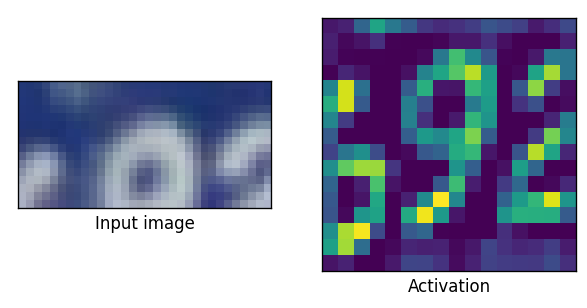

In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

The model performs okay in my opinion, with a small amount of epochs an accuracy of >80% can be achieved. The loss is very high the first epoch but then flattens down immediately. Unfreezing layers helps improves performance by a large margin, depending on how many layers you unfreeze. The model does seem to start overfitting when training for >=5 epochs, as we see an increase in the val_loss. (length: 397)



Max val score: 82.44%


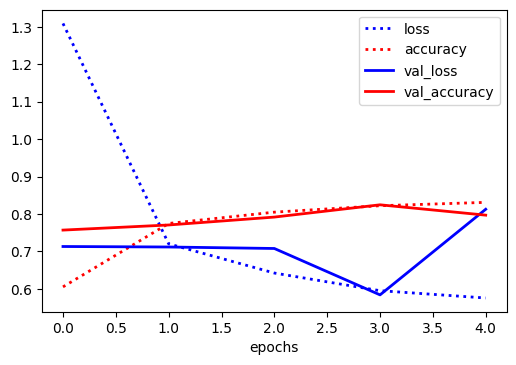

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)                5130      
Total params: 14,719,818
Trainable params: 9,444,362
Non-trainable params: 5,275,456
_________________________________________________________________
None
def build_model_4_1(use_output = True):

  model_4_1 = models.Sequential();
  
  # Get vgg16 without the top layers
  vgg16 = VGG16(input_shape=(32,32,3), include_top=False);
  # Freeze layers, leave last 6 unfrozen
  for layer in vgg16.layers[:-6]:
    layer.trainable = False

  model_4_1.add(vgg16)
  model_4_1.add(layers.Flatten())
  model_4_1.add(layers.D

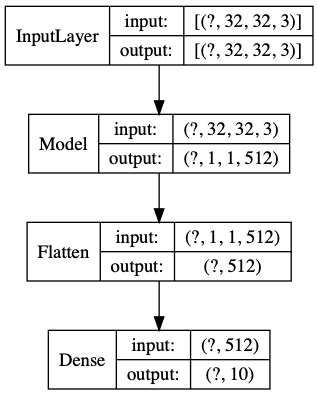

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

Tried to create embeddings of the model. (length: 41)

None
def store_embeddings():
  """ Stores all necessary embeddings to file
  """
  # Load model
  model_4_1 = load_model_from_file(base_dir, 'model_4_1')
  print(model_4_1.layers)

  # Take convolutional part of model
  conv = model_4_1.layers[0]
  print(conv.layers)
  
  # Make sure that layers are frozen
  for layer in conv.layers:
    layer.trainable = False

  # Compile model  
  conv.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  
  # Start with the embeddings
  output_train = conv.fit(X_train, y_train, epochs=1, batch_size=32,
                              verbose=1, validation_data=(X_val, y_val))
  output_test = conv.fit(X_train, y_train, epochs=1, batch_size=32,
                              verbose=1, validation_data=(X_val, y_val))
  print(output_train)

def evaluation_4_2(X_train, y_train, X_test, y_test):
  """ Runs 'evaluate_pipeline' with embe

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 12.29 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
